# <p style="padding:15px; background-color:#362FD9; font-family:JetBrains Mono; font-weight:bold; color:#000000; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 15px 15px; border: 5px solid #000000"> Multi-Label Classification with an Enzyme Substrate Dataset</p>

<p style="padding:15px; background-color:#000000; font-weight:bold; color:#362FD9; font-size:100%; border-radius: 10px 10px;">
    <b> Goal of the competition: </b>
<br>
The objective of this competition is to predict the probability of two of the targets (i.e  EC1 and EC2) in the test dataset. <br><br>
    <b> Evaluation Metric (=AUC): </b>
<br>
In this Kaggle challenge, submissions are evaluated on Area Under the ROC curve between the predicted probability and the ground truth for each target, and the final score is the average of the individual AUCs of each predicted column.
</p> 

# <p style="padding:15px; background-color:#525FE1; font-family:JetBrains Mono; font-weight:bold; color:#000000; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 15px 15px; border: 5px solid #000000"> I. Libraries && Data</p>

In [1]:
!pip install iterative-stratification

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing
from pandas.api.types import is_numeric_dtype
import seaborn as sns
sns.set_palette("bright")
import matplotlib.pyplot as plt

import optuna
from optuna.samplers import TPESampler

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.pipeline import Pipeline

# Models
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold, RepeatedMultilabelStratifiedKFold
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier


# Ignore warnings ;)
import warnings
warnings.simplefilter("ignore")

In [3]:
# files path
train_path     = "/kaggle/input/playground-series-s3e18/train.csv"
test_path      = "/kaggle/input/playground-series-s3e18/test.csv"

# function to import our dataset 
def import_data(train_path, test_path):     
    train      =  pd.read_csv(train_path)
    test       =  pd.read_csv(test_path)
    
    return train, test

train, test = import_data(train_path, test_path)

# <p style="padding:15px; background-color:#362FD9; font-family:JetBrains Mono; font-weight:bold; color:#000000; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 15px 15px; border: 5px solid #000000">II. Exploratory Data Analysis - EDA</p> 

In [4]:
train.head(5)

,id,BertzCT,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3v,Chi4n,EState_VSA1,...,SlogP_VSA3,VSA_EState9,fr_COO,fr_COO2,EC1,EC2,EC3,EC4,EC5,EC6
0,0,323.390782,9.879918,5.875576,5.875576,4.304757,4.304757,2.754513,1.749203,0.000000,...,4.794537,35.527357,0,0,1,1,0,0,0,0
1,1,273.723798,7.259037,4.441467,5.834958,3.285046,4.485235,2.201375,1.289775,45.135471,...,13.825658,44.707310,0,0,0,1,1,0,0,0
2,2,521.643822,10.911303,8.527859,11.050864,6.665291,9.519706,5.824822,1.770579,15.645394,...,17.964475,45.660120,0,0,1,1,0,0,1,0
3,3,567.431166,12.453343,7.089119,12.833709,6.478023,10.978151,7.914542,3.067181,95.639554,...,31.961948,87.509997,0,0,1,1,0,0,0,0
4,4,112.770735,4.414719,2.866236,2.866236,1.875634,1.875634,1.036450,0.727664,17.980451,...,9.589074,33.333333,2,2,1,0,1,1,1,0


In [5]:
test.head(5)

,id,BertzCT,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3v,Chi4n,EState_VSA1,...,PEOE_VSA14,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,SMR_VSA10,SMR_VSA5,SlogP_VSA3,VSA_EState9,fr_COO,fr_COO2
0,14838,344.632371,7.283603,4.473966,5.834958,3.412257,4.651530,2.096558,1.116433,49.458581,...,13.512441,0.000000,0.000000,0.000000,26.809272,24.539800,4.794537,47.304082,1,1
1,14839,1432.410201,10.663869,7.079026,8.065215,5.297097,5.297097,3.924155,2.569694,0.000000,...,0.000000,34.947374,98.323987,9.606882,0.000000,53.378235,0.000000,43.166667,0,0
2,14840,83.352608,3.931852,1.774215,1.774215,1.073446,1.073446,0.467830,0.170838,5.969305,...,5.969305,0.000000,0.000000,6.420822,11.752550,13.344559,9.589074,24.666667,1,1
3,14841,150.255712,5.912790,3.548812,3.548812,2.595128,2.595128,1.642813,0.694113,0.000000,...,59.935299,0.000000,0.000000,0.000000,17.744066,32.290168,4.794537,26.778866,0,0
4,14842,1817.276351,24.910940,15.540529,20.047314,12.535886,17.730988,11.979618,4.431173,84.554972,...,23.468091,25.609359,0.000000,37.099000,69.141353,38.704130,50.697492,102.583333,0,0


<p style="padding:15px; background-color:#000000; font-weight:bold; color:#362FD9; font-size:100%; border-radius: 15px 15px;">
    <b>💡 Let's take a look at some descriptive statistics.<br>
To achieve this, we will define our own functions for univariate statistics and bivariate statistics with more informations such as the mode, skewness and kurtosis...
</b>
</p> 

# <p style="padding:15px; background-color:#362FD9; font-family:JetBrains Mono; font-weight:bold; color:#000000; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 15px 15px; border: 5px solid #000000">1. Univariate Stats</p> 

In [6]:
# fonction to calculate univariate stats like pandas describe method
def univariate_stats(df):
    #df.drop('id', axis=1, inplace=True)
    output_df = pd.DataFrame(columns=['Count', 'Missing', 'Unique', 'Dtype', 'IsNumeric', 'Mode', 'Mean', 'Min', '25%', 'Median', '75%', 'Max', 'Std', 'Skew', 'Kurt'])
    
    for col in df:
        if is_numeric_dtype(df[col]):
            output_df.loc[col] = [df[col].count(), df[col].isnull().sum(), df[col].nunique(), df[col].dtype, is_numeric_dtype(df[col]), df[col].mode().values[0], df[col].mean(), df[col].min(), df[col].quantile(.25), df[col].median(), df[col].quantile(.75), df[col].max(), df[col].std(), df[col].skew(), df[col].kurt() ]
        else:
            output_df.loc[col] = [df[col].count(), df[col].isnull().sum(), df[col].nunique(), df[col].dtype, is_numeric_dtype(df[col]), df[col].mode().values[0], '-', '-', '-', '-', '-', '-', '-', '-', '-' ]

    return output_df.sort_values(by=['IsNumeric', 'Unique'], ascending=False)


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [7]:
# Call the function on train
univariate_stats(train)

,Count,Missing,Unique,Dtype,IsNumeric,Mode,Mean,Min,25%,Median,75%,Max,Std,Skew,Kurt
id,14838,0,14838,int64,True,0.000000,7418.500000,0.000000,3709.250000,7418.500000,11127.750000,14837.000000,4283.505982,0.000000,-1.200000
Chi2v,14838,0,3725,float64,True,2.719449,5.253221,0.000000,2.034468,3.242775,6.609350,34.579313,4.925065,1.748260,2.819865
Chi2n,14838,0,3634,float64,True,2.719449,4.432570,0.000000,1.949719,2.970427,5.788793,32.195368,3.760516,1.667144,3.033378
Chi3v,14838,0,3448,float64,True,0.000000,3.418749,0.000000,1.160763,1.948613,4.502070,22.880836,3.436208,1.644531,2.534616
Chi1v,14838,0,3306,float64,True,5.829902,6.738497,0.000000,2.932842,4.392859,8.527859,53.431954,5.866444,1.782578,3.112454
Chi1n,14838,0,3157,float64,True,3.562009,5.854307,0.000000,2.844556,4.052701,7.486791,50.174588,4.647064,1.722855,3.467028
Chi4n,14838,0,2930,float64,True,0.000000,1.773472,0.000000,0.503897,1.073261,2.534281,16.072810,1.865898,1.893930,5.154985
BertzCT,14838,0,2368,float64,True,146.218849,515.153604,0.000000,149.103601,290.987941,652.652585,4069.959780,542.456370,1.775677,2.939466
MaxAbsEStateIndex,14838,0,2356,float64,True,10.740912,10.556443,0.000000,9.926190,10.421334,11.539743,15.630251,1.559331,-1.698735,7.697682
Kappa3,14838,0,2245,float64,True,13.350621,5.874372,-104.040000,1.784008,3.261011,5.848400,1512.242231,45.730226,26.419611,764.704780


In [8]:
# Call the function to check univariate stats on test dataset
univariate_stats(test)

,Count,Missing,Unique,Dtype,IsNumeric,Mode,Mean,Min,25%,Median,75%,Max,Std,Skew,Kurt
id,9893,0,9893,int64,True,14838.000000,19784.000000,14838.000000,17311.000000,19784.000000,22257.000000,24730.000000,2856.007440,0.000000,-1.200000
Chi2v,9893,0,2858,float64,True,0.000000,5.247994,0.000000,2.049137,3.168052,6.516914,44.726398,4.939702,1.768094,3.026942
Chi2n,9893,0,2806,float64,True,0.000000,4.428979,0.000000,1.949719,2.930013,5.788793,36.368883,3.770031,1.703902,3.429600
Chi3v,9893,0,2644,float64,True,0.000000,3.401083,0.000000,1.171060,1.923982,4.302610,26.736931,3.431766,1.655561,2.546061
Chi1v,9893,0,2604,float64,True,5.829902,6.733659,0.000000,2.934030,4.337841,8.528316,53.990574,5.863886,1.776381,3.124391
Chi1n,9893,0,2473,float64,True,0.000000,5.848047,0.000000,2.846050,4.009996,7.490880,43.283925,4.641662,1.699450,3.223587
Chi4n,9893,0,2249,float64,True,0.000000,1.750078,0.000000,0.508512,1.058931,2.509394,15.620667,1.837159,1.849665,4.728521
MaxAbsEStateIndex,9893,0,1924,float64,True,10.740912,10.555415,0.000000,9.946009,10.418624,11.526326,14.630251,1.572745,-1.849550,8.438563
BertzCT,9893,0,1811,float64,True,146.218849,516.411916,0.000000,150.255712,289.901774,652.758463,3919.541449,544.327795,1.757376,2.773652
Kappa3,9893,0,1775,float64,True,3.479710,5.280890,-104.040000,1.788507,3.261011,5.772640,1512.242231,37.349006,29.556572,982.142731


<p style="padding:15px; background-color:#000000; font-weight:bold; color:#362FD9; font-size:100%; border-radius: 15px 15px;">
    <b>💡 Some remarks: <br>
+) There are no missing values in the train and the test dataset <br>
+) Most of the columns are not normally distributed (most of them are right skewed)<br><br>
        Let's visualize some graphics to gain more insights. <br>
</b>
</p> 

In [9]:
target_1 = 'EC1'
target_2 = 'EC2'
train = train.drop(['id', 'EC3', 'EC4', 'EC5', 'EC6'], axis=1)

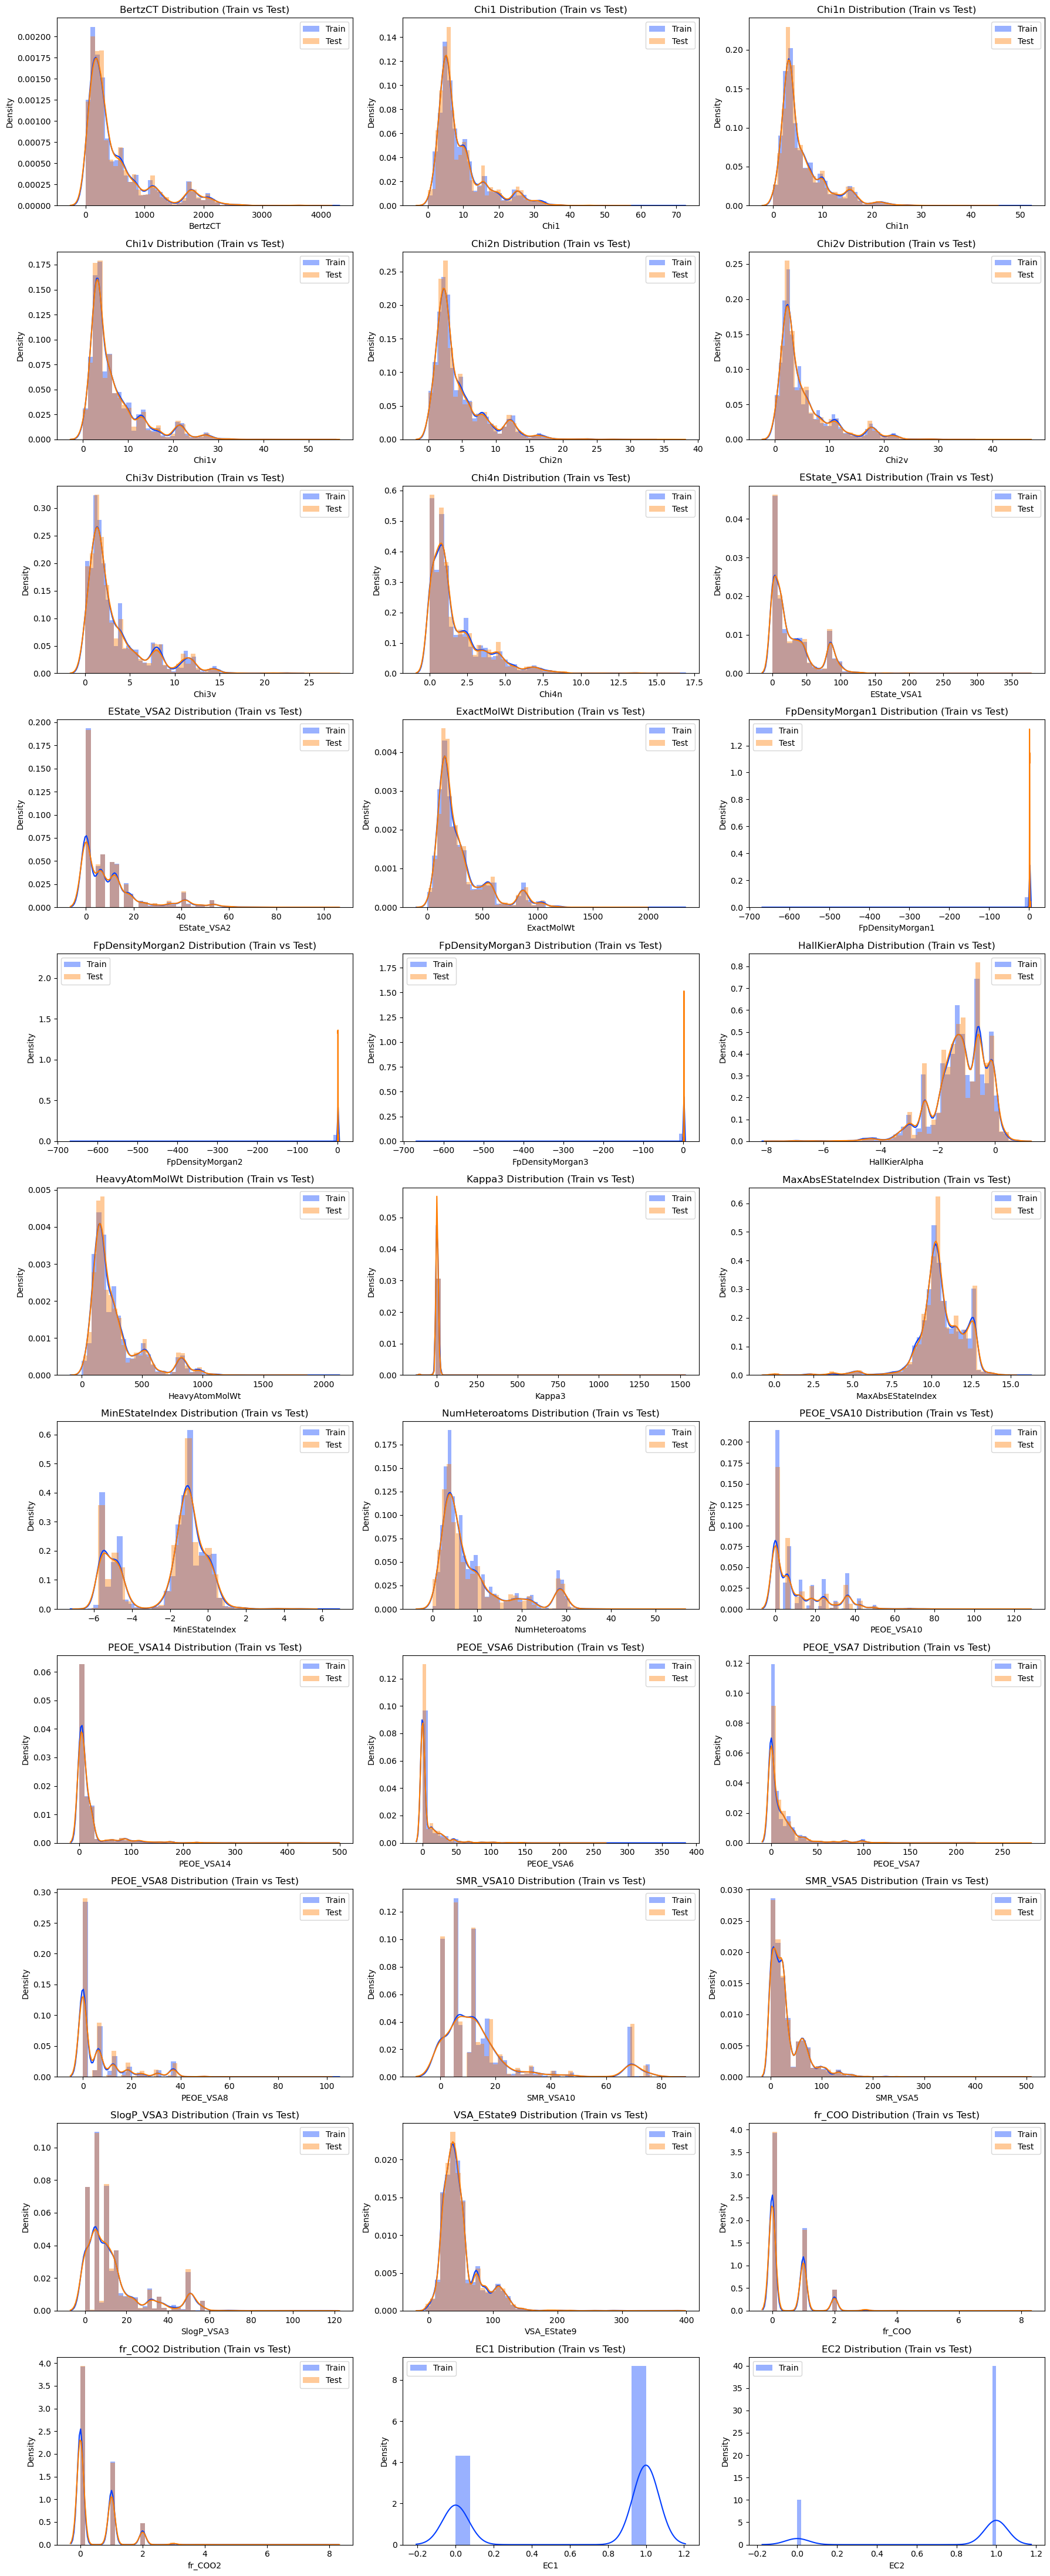

In [10]:
def plot_histograms(df_train, df_test, target, n_cols=3):
    n_rows = (len(df_train.columns) - 1) // n_cols + 1
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 4*n_rows))
    axes = axes.flatten()

    for i, var_name in enumerate(df_train.columns.tolist()):
        ax = axes[i]
        sns.distplot(df_train[var_name], kde=True, ax=ax, label='Train')
        if var_name != target_1 and var_name != target_2:
            sns.distplot(df_test[var_name], kde=True, ax=ax, label='Test')
        ax.set_title(f'{var_name} Distribution (Train vs Test)')
        ax.legend()

    plt.tight_layout()
    plt.show()
        
plot_histograms(train, test, target_1, n_cols=3)

In [11]:
#function to visualize the binary EC1 and EC2
def plot_binary(dataframe, column):
    plt.figure(figsize=(10, 4))

    # Countplot for Machine failure
    ax = plt.subplot(1, 2, 1)
    ax = sns.countplot(x=column, data=dataframe)
    ax.bar_label(ax.containers[0])
    plt.title(column, fontsize=20)

    # Pie chart for Outcome
    ax = plt.subplot(1, 2, 2)
    outcome_counts = dataframe[column].value_counts()
    ax = outcome_counts.plot.pie(explode=[0.1, 0.1], autopct='%1.2f%%', shadow=True)
    ax.set_title("Pie Chart Graph", fontsize=20, color='Red', font='Lucida Calligraphy')

    # Display the plot
    plt.tight_layout()
    plt.show()

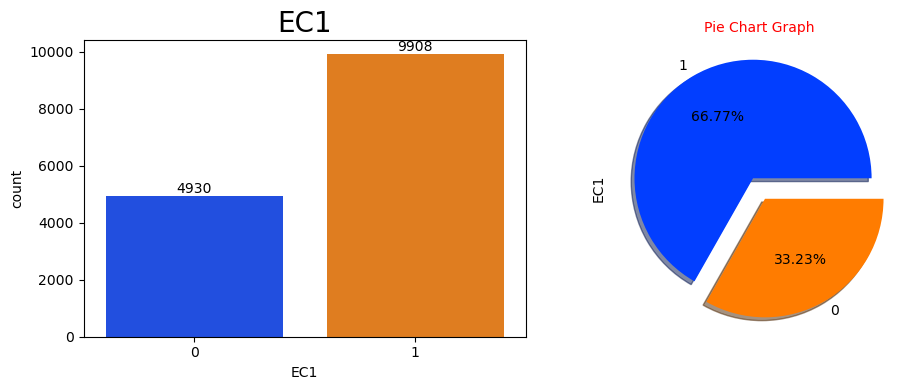

In [12]:
# Visualize the machine failure
plot_binary(train, target_1)

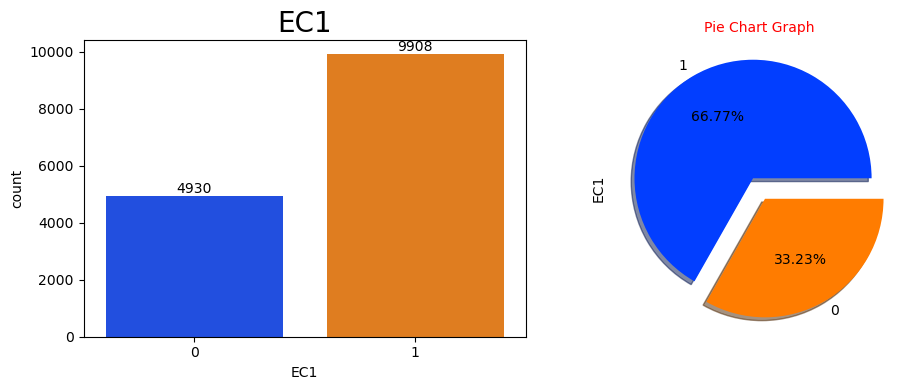

In [13]:
plot_binary(train, target_1)

<p style="padding:15px; background-color:#000000; font-weight:bold; color:#362FD9; font-size:100%; border-radius: 15px 15px;">
    <b>💡 Additional Insights:<br><br>
+) From the above analysis, it can be seen that the dataset is imbalanced <br>
+) The train and the test datasets seem to have same characteristics <br> 
+) Many features have the same distributions( for example 'Chi1v', 'Chi1n', 'Chi2n', 'Chi2v', 'Chi3v', 'Chi4n' have almost the same distribution)
</b>
</p> 

# <p style="padding:15px; background-color:#362FD9; font-family:JetBrains Mono; font-weight:bold; color:#000000; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 15px 15px; border: 5px solid #000000">2. Bivariate Stats</p> 

<p style="padding:15px; background-color:#000000; font-weight:bold; color:#362FD9; font-size:100%; border-radius: 15px 15px;">
    <b>💡 Recall: There are three types of bivariate analysis.</b><br>       
<ul> 
<li> <b>Numerical - Numerical: Pearson's Correlation</b> </li> <br>
The correlation represents the strength of a linear relationship between two numerical variables. If there is no correlation between the two variables, there is no tendency to change along with the values of the second quantity.  <br>  <br>
<li> <b>Categorical - Numerical: one-way ANOVA(3 + groups) or t-test (exactly 2 groups)</b>       </li> <br>
The ANOVA test is used to determine whether there is a significant difference among the averages of more than two groups that are statistically different from each other. <br><br>
<li> <b>Categorical - Categorical: Chi-square Test</b>       </li> <br>
It is calculated based on the difference between expected frequencies and the observed frequencies in one or more categories of the frequency table.
</ul>
</p> 

In [14]:
# this just an intermediate function that will be used in bivstats for one-way ANOVA
def anova(df, feature, label):
    import pandas as pd
    import numpy as np
    from scipy import stats
    
    groups = df[feature].unique()
    df_grouped = df.groupby(feature)
    group_labels = []
    for g in groups:
        g_list = df_grouped.get_group(g)
        group_labels.append(g_list[label])
        
    return stats.f_oneway(*group_labels)

# function to calculate bivariate stats; Pearson' correlation, p-value and one-way ANOVA
def bivstats(df, label):
    from scipy import stats
    import pandas as pd
    import numpy as np
    
    # Create an empty DataFrame to store output
    output_df = pd.DataFrame(columns=['Stat', '+1/-1 * ', 'Effect size', 'p-value'])
    
    for col in df:
        if col != label:
            if df[col].isnull().sum() == 0:
                if is_numeric_dtype(df[col]):   # Calculate r and p
                    r, p = stats.pearsonr(df[label], df[col])
                    output_df.loc[col] = ['r', np.sign(r), abs(round(r, 3)), round(p,6)]
                    
                else:
                    F, p = anova(df[[col, label]], col, label)
                    output_df.loc[col] = ['F', '', round(F, 3), round(p,6)]
                    
            else:
                output_df.loc[col] = [np.nan, np.nan, np.nan, np.nan]

    return output_df.sort_values(by=['Effect size', 'Stat'], ascending=[False, False])
 
pd.options.display.float_format = '{:.5f}'.format

In [15]:
bivstats(train, target_1)

,Stat,+1/-1 *,Effect size,p-value
MinEStateIndex,r,1.00000,0.20900,0.00000
EState_VSA1,r,-1.00000,0.17400,0.00000
EC2,r,-1.00000,0.14600,0.00000
NumHeteroatoms,r,-1.00000,0.12700,0.00000
MaxAbsEStateIndex,r,-1.00000,0.12300,0.00000
PEOE_VSA14,r,-1.00000,0.12300,0.00000
PEOE_VSA10,r,-1.00000,0.11500,0.00000
SlogP_VSA3,r,-1.00000,0.10900,0.00000
VSA_EState9,r,-1.00000,0.09400,0.00000
PEOE_VSA6,r,1.00000,0.08500,0.00000


In [16]:
bivstats(train, target_2)

,Stat,+1/-1 *,Effect size,p-value
EC1,r,-1.00000,0.14600,0.00000
fr_COO,r,-1.00000,0.06900,0.00000
fr_COO2,r,-1.00000,0.06800,0.00000
PEOE_VSA8,r,-1.00000,0.04400,0.00000
SMR_VSA10,r,-1.00000,0.04200,0.00000
HallKierAlpha,r,1.00000,0.04000,0.00000
PEOE_VSA6,r,-1.00000,0.04000,0.00000
EState_VSA2,r,-1.00000,0.03400,0.00003
VSA_EState9,r,-1.00000,0.03400,0.00003
MaxAbsEStateIndex,r,-1.00000,0.03100,0.00014


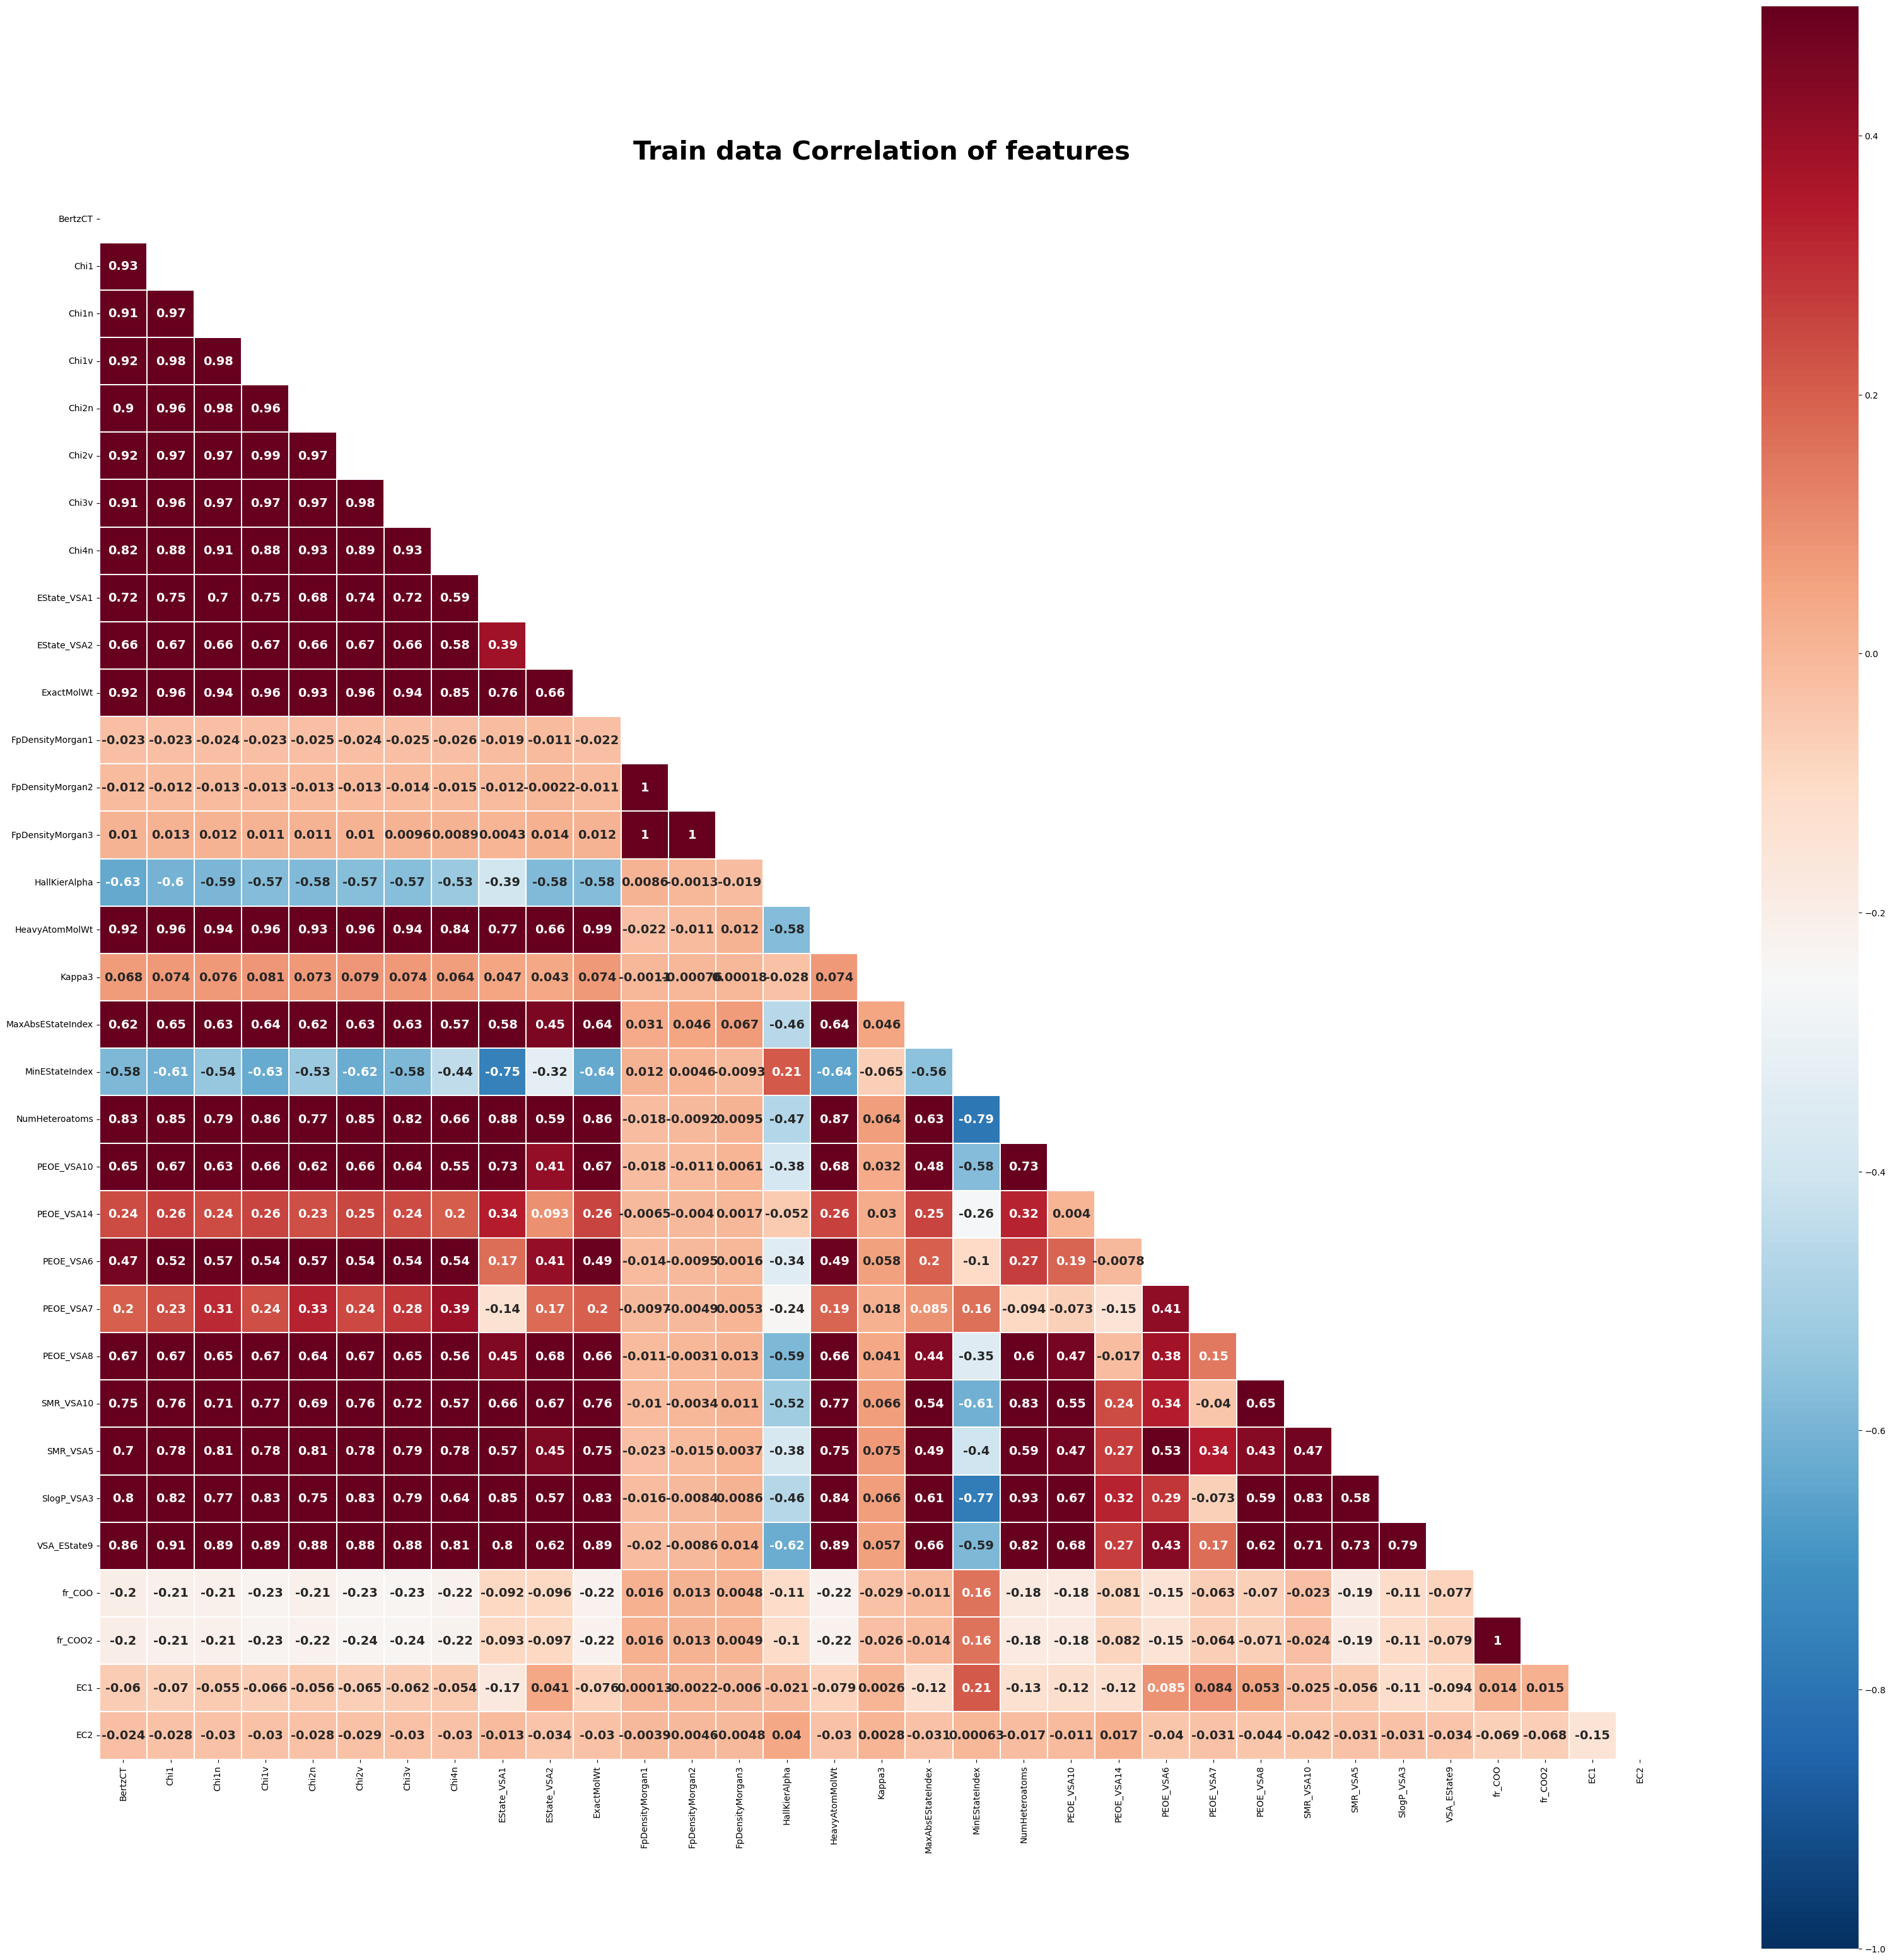

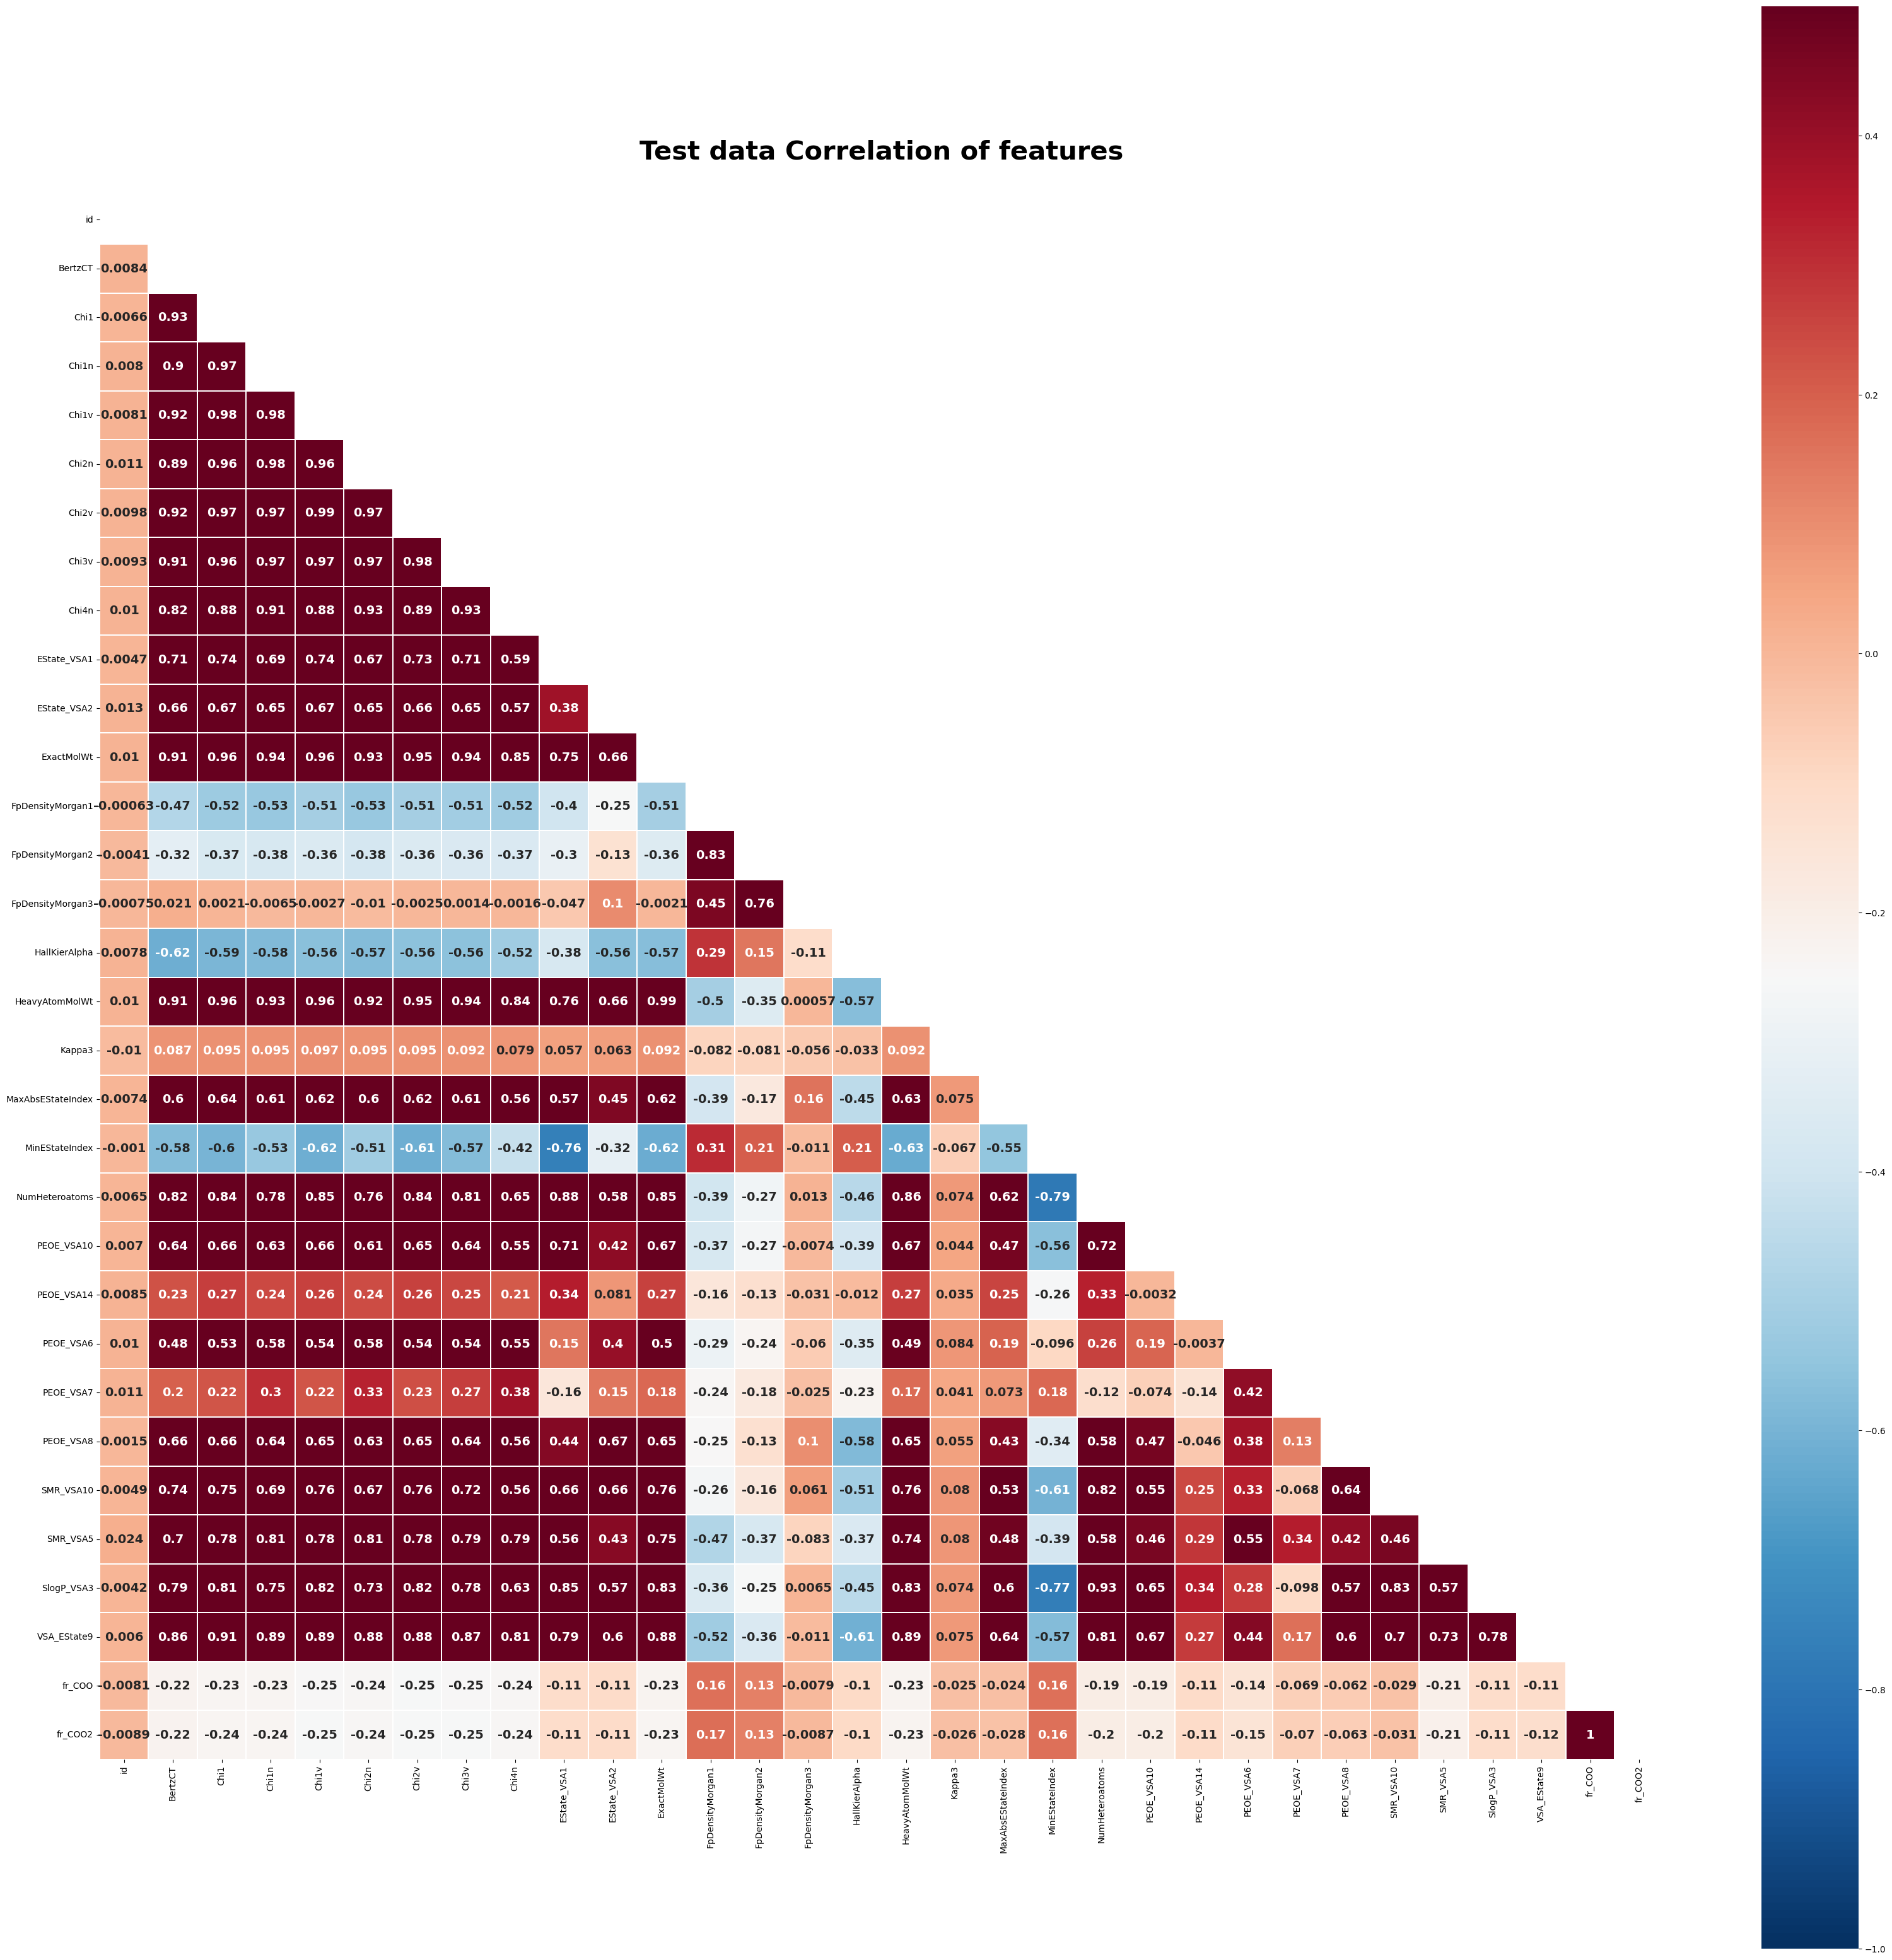

In [17]:
def plot_heatmap(df, title):
    # Create a mask for the diagonal elements
    mask = np.zeros_like(df.astype(float).corr())
    mask[np.triu_indices_from(mask)] = True

    # Set the colormap and figure size
    colormap = plt.cm.RdBu_r
    plt.figure(figsize=(40, 40))

    # Set the title and font properties
    plt.title(f'{title} Correlation of features', fontweight='bold', y=1.02, size=30)

    # Plot the heatmap with the masked diagonal elements
    sns.heatmap(df.astype(float).corr(), linewidths=0.1, vmax=0.5, vmin=-1.0, 
                square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size": 14, "weight": "bold"},
                mask=mask)

plot_heatmap(train, title='Train data')
plot_heatmap(test, title='Test data')

<p style="padding:15px; background-color:#000000; font-weight:bold; color:#362FD9; font-size:100%; border-radius: 15px 15px;">
    <b>💡 Insights : <br>
        +) There is a strong correlation between certain columns of the dataset therefore I'll drop some of the columns which have high correlation between each other. <br>
        +) Applying PCA to reduce the number of features might be a good idea.
</b>
</p> 

# <p style="padding:15px; background-color:#362FD9; font-family:JetBrains Mono; font-weight:bold; color:#000000; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 15px 15px; border: 5px solid #000000">III. Feature Engineering</p> 

<p style="padding:15px; background-color:#000000; font-weight:bold; color:#362FD9; font-size:100%; border-radius: 15px 15px;">
    <b>💡 Dealing with features : <br><br>
        When dealing with a highly imbalanced dataset, feature engineering can play a crucial role in improving the performance of our machine learning models. <br>
        Removing certain features that are highly correlated could improve the performance of our models. Also, the addition of other features could also be an asset.
</b>
</p> 

In [18]:
# function to add more features to the dataset
def feature_engineering(df): 
    # Dropping correlated features
    df.drop(['fr_COO2', 'FpDensityMorgan2', 'FpDensityMorgan3', 'Chi1v', 'Chi1n', 'Chi2n', 'Chi2v', 'Chi3v', 'Chi4n'], axis=1,inplace=True)
    
    # Adding new features
   
    return df

In [19]:
# adding features
train_eng  = feature_engineering(train)
test_eng   = feature_engineering(test)

train_eng.head()

,BertzCT,Chi1,EState_VSA1,EState_VSA2,ExactMolWt,FpDensityMorgan1,HallKierAlpha,HeavyAtomMolWt,Kappa3,MaxAbsEStateIndex,MinEStateIndex,NumHeteroatoms,PEOE_VSA10,PEOE_VSA14,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,SMR_VSA10,SMR_VSA5,SlogP_VSA3,VSA_EState9,fr_COO,EC1,EC2
0,323.39078,9.87992,0.00000,11.93829,222.06808,1.18182,-0.24000,212.16300,8.17000,11.92250,0.17159,4,0.00000,91.53649,0.00000,0.00000,0.00000,17.74407,0.00000,4.79454,35.52736,0,1,1
1,273.72380,7.25904,45.13547,0.00000,260.02972,1.34615,-0.09000,247.03100,3.20149,10.93234,-4.83045,10,24.41587,7.82270,0.00000,0.00000,0.00000,7.82270,30.70589,13.82566,44.70731,0,0,1
2,521.64382,10.91130,15.64539,6.60688,382.13103,1.08571,-0.78000,354.10600,15.03389,11.23805,-5.06626,9,0.00000,15.64539,0.00000,53.37824,0.00000,15.64539,73.14362,17.96448,45.66012,0,1,1
3,567.43117,12.45334,95.63955,0.00000,530.07028,1.16279,-1.30000,506.12400,6.72430,11.17117,-5.27658,19,42.72776,21.33514,0.00000,0.00000,6.42082,15.64539,62.10730,31.96195,87.51000,0,1,1
4,112.77073,4.41472,17.98045,12.84164,118.06299,1.44444,-1.10000,108.05600,3.93127,9.85574,-1.67630,4,6.04184,11.93861,6.92374,19.38640,0.00000,11.93861,18.88348,9.58907,33.33333,2,1,0


In [20]:
# Prepare our dataset
test_eng.drop(columns= ["id"], inplace=True, axis=1)
test_eng.head(3)

,BertzCT,Chi1,EState_VSA1,EState_VSA2,ExactMolWt,FpDensityMorgan1,HallKierAlpha,HeavyAtomMolWt,Kappa3,MaxAbsEStateIndex,MinEStateIndex,NumHeteroatoms,PEOE_VSA10,PEOE_VSA14,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,SMR_VSA10,SMR_VSA5,SlogP_VSA3,VSA_EState9,fr_COO
0,344.63237,7.28360,49.45858,0.00000,204.07971,1.38462,-0.24000,192.19700,3.24712,10.24869,-4.73464,7,18.31190,13.51244,0.00000,0.00000,0.00000,26.80927,24.53980,4.79454,47.30408,1
1,1432.41020,10.66387,0.00000,29.78317,315.21033,0.57143,-1.81000,280.26300,10.07000,11.91793,-0.30333,4,0.00000,0.00000,34.94737,98.32399,9.60688,0.00000,53.37824,0.00000,43.16667,0
2,83.35261,3.93185,5.96931,6.42082,101.04768,1.50000,-0.86000,94.04900,5.43000,9.69444,-0.83333,3,0.00000,5.96931,0.00000,0.00000,6.42082,11.75255,13.34456,9.58907,24.66667,1


<p style="padding:15px; background-color:#000000; font-weight:bold; color:#362FD9; font-size:100%; border-radius: 15px 15px;">
    <b>💡 Encoding & Scaling: <br><br>
        For this task I'll use XGBoostClassifier(which is a Gradient Boosting Decision Trees - GBDT model) so encoding and scaling may not be necessary here.

</b>
</p> 

In [21]:
y  = train_eng[['EC1', 'EC2']]
X  = train_eng.drop(columns=['EC1', 'EC2'], axis=1)

In [22]:
y.head()

,EC1,EC2
0,1,1
1,0,1
2,1,1
3,1,1
4,1,0


# <p style="padding:15px; background-color:#362FD9; font-family:JetBrains Mono; font-weight:bold; color:#000000; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 15px 15px; border: 5px solid #000000">IV. XGBoost Model building</p>

# **1. Basic Approach**

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state = 42)

In [24]:
basic_params = {
                 'tree_method': 'hist',
                 'max_depth': 4,
                 'reg_alpha': 1,
                 'reg_lambda': 5,
                 'min_child_weight': 3,
                 'gamma': 2,
                 'learning_rate': 0.160702260563716,
                 'eval_metric': 'auc',
                 'colsample_bytree': 0.77,
                 'colsample_bynode': 0.14,
                 'colsample_bylevel': 0.74,
                 'subsample': 0.95
                }

basic_classifier = MultiOutputClassifier(XGBClassifier(**basic_params))

basic_clf = Pipeline([
                # Add a transformer here
                ('classifier', basic_classifier)
               ])

#_ = basic_clf.set_params(**basic_params)

In [25]:
basic_clf.fit(X_train, y_train)

# We'll predict the test data.
basic_preds = np.array(basic_clf.predict(X_val))
basic_preds

array([[1, 1],
       [0, 1],
       [1, 1],
       ...,
       [1, 1],
       [0, 1],
       [1, 1]])

In [26]:
def print_evaluation(true_labels, predictions, i):
    # Calculate the AUC
    auc = roc_auc_score(true_labels.iloc[:,i], predictions[:,i])
    print(f"ROC AUC ====> EC{i+1}: {auc} \n")

    # Display classification report
    print("Classification Report for : EC1 \n")
    cf_report = classification_report(true_labels.iloc[:,i], predictions[:,i])
    print(cf_report)
    
    # Plot the confusion
    print("Confusion Matrix for : EC1 \n")
    cf_matrix = confusion_matrix(true_labels.iloc[:,i], predictions[:,i])
    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
                fmt='.2%', cmap='Blues')

ROC AUC ====> EC1: 0.6111988939364013 

Classification Report for : EC1 

              precision    recall  f1-score   support

           0       0.57      0.35      0.43       976
           1       0.73      0.87      0.80      1992

    accuracy                           0.70      2968
   macro avg       0.65      0.61      0.62      2968
weighted avg       0.68      0.70      0.68      2968

Confusion Matrix for : EC1 



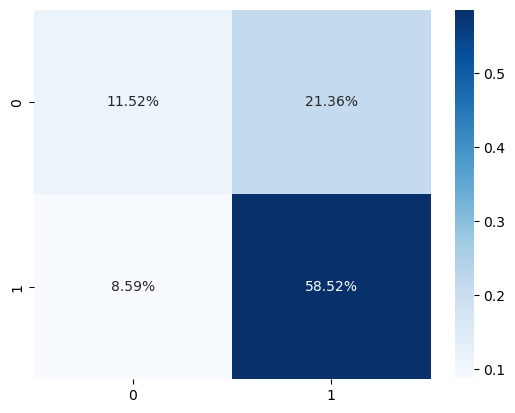

In [27]:
print_evaluation(y_val, basic_preds, 0)

ROC AUC ====> EC2: 0.5 

Classification Report for : EC1 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       568
           1       0.81      1.00      0.89      2400

    accuracy                           0.81      2968
   macro avg       0.40      0.50      0.45      2968
weighted avg       0.65      0.81      0.72      2968

Confusion Matrix for : EC1 



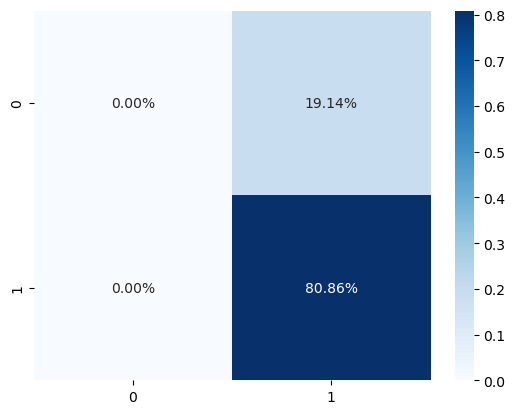

In [28]:
print_evaluation(y_val, basic_preds, 1)

# **2. Improved approach**

<p style="padding:15px; background-color:#000000; font-weight:bold; color:#362FD9; font-size:100%; border-radius: 15px 15px;">
    <b>💡 Stratification: <br><br>
        From the library "iterative-stratification" we'll use MultilabelStratifiedKFold to stratify the dataset. <br>
        This might come in handy since we have an unbalanced distribution.

</b>
</p> 

In [29]:
oof_preds = np.zeros(y.shape)
test_preds = np.zeros((test.shape[0], y.shape[1]))
oof_losses = []

kf = RepeatedMultilabelStratifiedKFold(n_splits=7, n_repeats=3, random_state=0)

for fn, (trn_idx, val_idx) in enumerate(kf.split(X, y)):
    print('Starting fold: ', fn)
    X_train, X_val = X.iloc[trn_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[trn_idx], y.iloc[val_idx]
    
    basic_clf.fit(X_train, y_train)
    val_preds = basic_clf.predict_proba(X_val) # list of preds per class
    val_preds = np.array(val_preds)[:,:,1].T # take the positive class
    oof_preds[val_idx] = val_preds
    
    loss = roc_auc_score(np.ravel(y_val), np.ravel(val_preds))
    oof_losses.append(loss)
    preds = basic_clf.predict_proba(test_eng)
    preds = np.array(preds)[:,:,1].T # take the positive class
    test_preds += preds / 5
    
    print('Fold', fn, ':=======> XGBoost oof ROC-AUC :=======>', loss)
    
#print(oof_losses)
print('\n\nMean OOF loss across folds: ', np.mean(oof_losses))
print( 'STD OOF loss across folds: ', np.std(oof_losses))

Starting fold:  0
Fold 0 :=======> XGBoost oof ROC-AUC :=======> 0.6767014680000546
Starting fold:  1
Fold 1 :=======> XGBoost oof ROC-AUC :=======> 0.6636111032068975
Starting fold:  2
Fold 2 :=======> XGBoost oof ROC-AUC :=======> 0.6791660413568541
Starting fold:  3
Fold 3 :=======> XGBoost oof ROC-AUC :=======> 0.676150555743728
Starting fold:  4
Fold 4 :=======> XGBoost oof ROC-AUC :=======> 0.6870198267209601
Starting fold:  5
Fold 5 :=======> XGBoost oof ROC-AUC :=======> 0.6860006136645488
Starting fold:  6
Fold 6 :=======> XGBoost oof ROC-AUC :=======> 0.6654771931821415
Starting fold:  7
Fold 7 :=======> XGBoost oof ROC-AUC :=======> 0.6653788922756614
Starting fold:  8
Fold 8 :=======> XGBoost oof ROC-AUC :=======> 0.6785462740630586
Starting fold:  9
Fold 9 :=======> XGBoost oof ROC-AUC :=======> 0.6758908390975529
Starting fold:  10
Fold 10 :=======> XGBoost oof ROC-AUC :=======> 0.6847118914150756
Starting fold:  11
Fold 11 :=======> XGBoost oof ROC-AUC :=======> 0.671650

In [30]:
basic_clf.fit(X, y)
total_preds = basic_clf.predict_proba(X)
total_preds = np.array(total_preds)[:,:,1].T
total_preds

array([[0.736013  , 0.8462332 ],
       [0.27433318, 0.87419873],
       [0.50568545, 0.8465438 ],
       ...,
       [0.6441204 , 0.85627127],
       [0.5419163 , 0.84290034],
       [0.47463727, 0.81290036]], dtype=float32)

ROC AUC ====> EC1: 0.6371488894584744 

Classification Report for : EC1 

              precision    recall  f1-score   support

           0       0.63      0.39      0.48      4930
           1       0.74      0.88      0.81      9908

    accuracy                           0.72     14838
   macro avg       0.69      0.64      0.64     14838
weighted avg       0.71      0.72      0.70     14838

Confusion Matrix for : EC1 



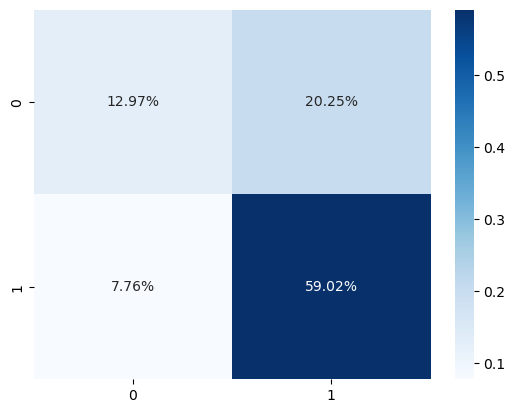

In [31]:
total_preds = basic_clf.predict(X)
print_evaluation(y, total_preds, 0)

ROC AUC ====> EC2: 0.5 

Classification Report for : EC1 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2983
           1       0.80      1.00      0.89     11855

    accuracy                           0.80     14838
   macro avg       0.40      0.50      0.44     14838
weighted avg       0.64      0.80      0.71     14838

Confusion Matrix for : EC1 



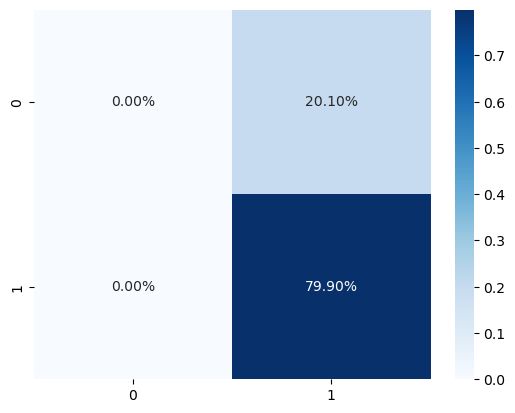

In [32]:
print_evaluation(y, total_preds, 1)

<p style="padding:15px; background-color:#000000; font-weight:bold; color:#362FD9; font-size:100%; border-radius: 15px 15px;">
    <b>💡 Getting feature importance : <br></b>
Sklearn's MultiOutputClassifier has no attribute feature_importances_ but we can access the feature importances of each XGBoostClassifier, and then average them all together to give each feature's average importance, across all XGBoost Classifiers. <br>
MultiOutputClassifier objects have an attribute called estimators_ that gives a list containing an object for each classifier. For each of these XGBoost classifier objects, we can access its feature importances through the feature_importances_ attribute.
    </p>

In [33]:
xgb_estimators = basic_clf[0].estimators_

feature_importances = [] 
for clf in xgb_estimators:
    feature_importances.append(clf.feature_importances_)
mean_feature_importances = np.mean(feature_importances, axis=0).tolist()

feature_names = X.columns
for score, name in sorted(zip(mean_feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, score))

MinEStateIndex: 0.0930725559592247
NumHeteroatoms: 0.08844033628702164
fr_COO: 0.060696475207805634
EState_VSA1: 0.05792009085416794
Kappa3: 0.0547483004629612
ExactMolWt: 0.05467841029167175
VSA_EState9: 0.05093453451991081
SlogP_VSA3: 0.04986331984400749
PEOE_VSA10: 0.04705347865819931
PEOE_VSA14: 0.04628197103738785
HeavyAtomMolWt: 0.04521605372428894
Chi1: 0.04385226219892502
SMR_VSA10: 0.03828251361846924
PEOE_VSA7: 0.037685997784137726
PEOE_VSA6: 0.03568463772535324
PEOE_VSA8: 0.032436955720186234
FpDensityMorgan1: 0.029510045424103737
HallKierAlpha: 0.02887081354856491
EState_VSA2: 0.028841914609074593
SMR_VSA5: 0.026372767984867096
BertzCT: 0.02511962689459324
MaxAbsEStateIndex: 0.02443694695830345


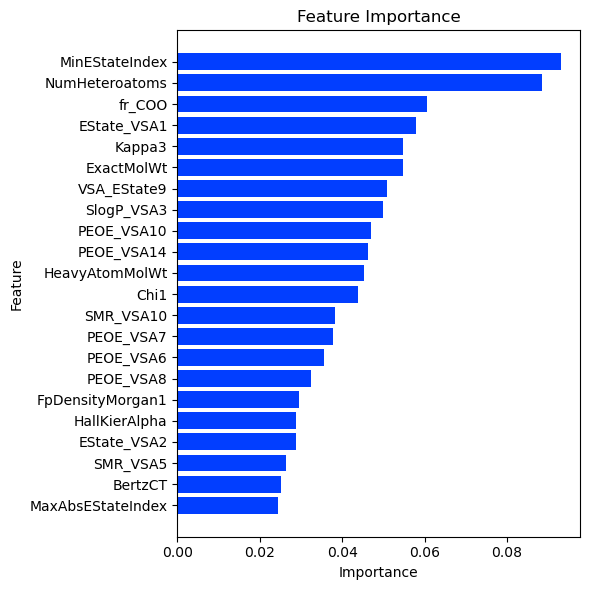

In [34]:
# Create a dataframe with feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': mean_feature_importances})

# Sort the dataframe by importance scores in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)  # Sort in ascending order

# Create a vertical bar plot of feature importance
plt.figure(figsize=(6, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

In [35]:
total_preds = basic_clf.predict_proba(test_eng)
total_preds = np.array(total_preds)[:,:,1].T
total_preds

array([[0.4385724 , 0.78422326],
       [0.7952878 , 0.81019247],
       [0.8036172 , 0.7495718 ],
       ...,
       [0.36818463, 0.84509283],
       [0.47702593, 0.8582887 ],
       [0.35291114, 0.85372955]], dtype=float32)

# <p style="padding:15px; background-color:#362FD9; font-family:JetBrains Mono; font-weight:bold; color:#000000; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 15px 15px; border: 5px solid #000000">V. Baseline Submission</p>  

In [36]:
submission = pd.read_csv("/kaggle/input/playground-series-s3e18/sample_submission.csv")
submission.head()

,id,EC1,EC2
0,14838,0.50000,0.50000
1,14839,0.50000,0.50000
2,14840,0.50000,0.50000
3,14841,0.50000,0.50000
4,14842,0.50000,0.50000


In [37]:
# create the submission file
submission.iloc[:,1:] = total_preds
submission.to_csv('XGB_baseline_submission.csv', index=False)

<p style="padding:15px; background-color:#000000; font-weight:bold; color:#362FD9; font-size:100%; border-radius: 15px 15px;">
    <b>💡 Next Steps : <br></b>
+) Try other Gradient Boosting algorithms like LGBM, CatBoost, GB, AdaBoost... <br>
+) Ensembling may increase considerably our AUC<br>
+) Try adding the original Dataset<br>
+) Feature engineering<br>
+) Applying PCA could be an excellent idea<br>
+) Futher hyperparameters tuning<br><br>
    Thanks for reading 😁 !!!
</p>